## <font color=#41A317> **Implementation of  Logistic Regression Model and Maximum Likelihood Estimation** </font>

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import random
import warnings
from numpy.random import default_rng
from datetime import datetime
rng = default_rng(25)

"""""""""
(Ignoring calculation errors for division and logsum)
We could instead use scipy.special.logsumexp for fixing this error
But in order to make the code similar to the mathematical formulation 
We didn't use scipy.special.logsumexp
"""""""""
np.seterr(divide = 'ignore')
np.seterr(invalid='ignore')
warnings.filterwarnings('ignore')

## <font color=#41A317> Content </font>
1.  Formulation of Binary Classification Problem using Logistic Regression and Maximum Likelihood

2.   Solutions using Optimization Methods:

      2.1. First-order solution: Gradient method with fixed step 

      2.2. Second-order solution: Newton-Raphson method

      2.3  Improved first-order solution: Barzilai Borwein method

3.   Data Simulations and Implementation of Methods on:
      
      3.1 Two-Circle Binary Classification Dataset

      3.2 Rejection Sampling with Uniform target distribution 

      3.3 Rejection Sampling with Beta target distribution

      3.4 Logistic Regression with Correlated Features

4.   Analysis and Conclusions

##  <font color=#41A317> 1. Formulation of Binary Classification Problem using Logistic Regression and Maximum Likelihood </font>

Given a dataset $D = \left\{ \left(x_{i},y_{i} \right) \right\} _{1\le i\le n}$ of $n$ independent random samples of $\left(x,y\right)$ where $x \in \mathbb{X} \subseteq \mathbb{R}^d$ is a $d$-dimensional feature vector, and $y \in \{0,1\}$  is a binary class label, our goal is to build a binary classification rule <font color=#41A317> $f: \mathbb{X} \to \{0,1\}$</font> that predicts the class label $y$ given the feature vector $x$, using only the data $D$.

We assume that $y_{i}|X=x_{i} \sim \mathcal{Bern}( p(x_{i}))$ where the $p(x_i)$ the probability of $y_i$ given $x_i$ follows the logistic regression model:

$$p(x_{i}) = \frac{e^{\beta^\mathrm{T} \cdot x_i}}{1+e^{\beta^\mathrm{T} \cdot  x_i}}=\frac{1}{1+e^{-\beta^\mathrm{T}\cdot x_i}}= h_{\beta}(x_{i})$$


Here, $\beta \in \mathbb{R^{d}}$ is the parameter vector of the model, $h_{\beta}(x)$ is the sigmoid function, $\beta^\mathrm{T}\cdot x_i = \sum_{j=1}^{d}\beta_jx_{ij}$, and  $x_{i1}=1$ for all $i \in \{ 1, \cdots , n \}$. 

Our goal is *to estimate the parameter vector $\beta$ maximizing the likelihood function*: 

$$\hat{\beta} = \mathrm{argmax}_{\beta} {L_{n}(\beta)}$$

where:

 $$ L_{n}(\beta) = \prod_{1\le i\le n }   p(x_i) ^{y_i}(1-p(x_i))^{1-y_i} = \prod_{1\le i\le n } h_{\beta}(x_{i})^{y_{i}}(1-h_{\beta}(x_{i}))^{1-y_{i}}$$
 
 
We define the log-likelihood function $\ell_{n}(\beta)$ as:


$$ \ell_{n}(\beta) = \sum_{1\le i\le n} y_{i}\log(h_{\beta}(x_{i})) + (1-y_{i})\log(1-h_{\beta}(x_{i})) = \sum_{1\le i\le n} y_i (\beta^\mathrm{T} \cdot  x_i) - log(1+e^{\beta^\mathrm{T} \cdot  x_i}) $$ 



Since the logarithm is a monotonic function, we can maximize $\ell_{n}(\beta)$ to obtain the estimate $\hat{\beta}$ of the parameter vector. 

Finally, given fixed threshold $\gamma \in [0,1]$,  <font color=#41A317> the classification rule $f$</font>  is defined as:

 $$f(x_i,\gamma) = \left\{ \begin{array}{lcc}
             1  &   \text{if }  h_\hat{\beta}(x_i) \geq \gamma 
             \\ 0 &  \text{otherwise} 
             \end{array}
   \right.$$

which is equivalent to:

$$
f(x_i,\gamma) = \left\{ \begin{array}{lcc}
             1  &   \text{if } & 0 \le \beta^\mathrm{T} \cdot  x_i + \log(\frac{1}{\gamma}-1)
             \\ 0 &  \text{if } & 0 \gt  \beta^\mathrm{T} \cdot  x_i + \log(\frac{1}{\gamma}-1) 
             \end{array}
   \right.$$


This means that the hyperplane that separates the two sets is given by:

$$  \beta^\mathrm{T} \cdot  x + \log\left(\frac{1}{\gamma}-1\right) = 0$$

## <font color=#41A317> 2. Solutions using Optimization Methods </font>
In order to apply the minimization algorithms to estimate the parameter vector $\beta$, we will actually convert the objective function into the negative log likelihood function: $J_{n}(\beta^t):= - \ell_{n}(\beta^t)$

### <font color=#41A317>2.1.  First order solution : Gradient method with fixed step </font>

Gradient Descent is given by:
$$\beta^{(t+1)} = \beta^{(t)} - \rho \nabla J_{n}(\beta^{(t)}) $$
where:
* $\rho > 0$ and fixed
* $\nabla J_{n}(\beta^{(t)})$ is first order derivative (Gradient)
* $t$ is the current iteration

In order to calculate the Gradient descent equation we need to calculate the *gradient*:

$$\nabla J_{n}(\beta^{(t)}) = \left\langle\matrix{
\sum_{i=1}^{n}(h_{\beta^{(t)}}(x_{i})-y_{i})x_{i,j}\cr
}\right\rangle _{j = 1, \cdots,d}$$

#### Step 1.1
We start by defining our **sigmoid** function $h_{\beta}(x)$

In [ ]:
def h(x, beta):
    z = beta@x
    return 1/(1+np.exp(-z))

#### Step 1.2
We write a function $J_{n}(\beta)$ which takes as argument  the data $X,y$ and $\beta$ and returns the negative of the log-likelihood

In [ ]:
def log_likelihood_values(X,y,beta):
    #The output is the vector of negative values of log-likelihood
    X=pd.DataFrame(X)
    sigmoid_probs = X.apply(lambda x: h(x, beta), axis=1).values
    return -(y*np.log(sigmoid_probs) + (1-y)*np.log(1- sigmoid_probs))

def log_likelihood(X,y,beta):
    #The output is the negative of the log-likelihood
    X=pd.DataFrame(X)
    sigmoid_probs = X.apply(lambda x: h(x, beta), axis=1).values
    return -np.sum(y*np.log(sigmoid_probs) + (1-y)*np.log(1- sigmoid_probs))

#### Step 1.3
Now, we define the *gradient* $\nabla J_{n}(\beta)$

In [ ]:
def gradient(X, y, beta):                                                         
    X=pd.DataFrame(X)
    sigmoid_probs = np.array(X.apply(lambda x: h(x, beta), axis=1)) 
    return X.T@(sigmoid_probs-y)  

#### Step 1.4
In this step we will write a function that iterates $\beta^{(t)}$ by using *Gradient Descent with Constant Step Method* with a stopping creteria for: 
*  $\left\| J (\beta^{(t)}) - J (\beta^{(t+1)}) \right\| < 10^{-6}$
*  and maximum iterations

In [ ]:
def fixed_step(x,y,beta, max_iterations=500,rho=0.05):
    iterations = [beta]
    norm_grad = [np.linalg.norm(gradient(x,y,beta))]
    delta_l = np.Infinity
    l = log_likelihood(x, y, beta)
    loglike_values = [l]
    # Convergence Conditions                                                        
    δ = .000001                                                                                                                         
    i = 0                                                                           
    while abs(norm_grad[i]) > δ and i < max_iterations:                                       
        i += 1                                                                      
        g = gradient(x, y, beta)
        norm_grad.append(np.linalg.norm(g))                                                

        Δ = rho * g                                                                                                                                                                                                  
        # Perform our update step  
        beta = beta - Δ 
        
        # Update the log-likelihood at each iteration                                     
        l_new = log_likelihood(x, y,beta)                                                      
        delta_l = l - l_new                                                           
        l = l_new   
        loglike_values.append(l)
    return np.array(beta),np.array(loglike_values),i


### <font color=#41A317> 2.2. Second order solution : Newton-Raphson method </font>

Newton Raphson equation is given as

$$\beta^{(t+1)} = \beta^{(t)} - {H^{-1}_{J_{n}(\beta^{(t)})}}\nabla J_{n}(\beta^{(t)}) $$ 

where:

* $\nabla J_{n}(\beta^{(t)})$ is first order derivative (Gradient)
* $H_{J_{n}(\beta^{(t)})}$ is second order derivative (Hessian)
* $t$ is the current iteration.

In order to calculate the Newton-Raphson equation we need to calculate *Hessian* function:

$$H_{J_{n}(\beta^{(t)})} = \left\langle\matrix{
\sum_{i=1}^{n}h_{\beta^{(t)}}(x_{i})(1-h_{\beta^{(t)}}(x_{i}))x_{i,j}x_{i,k}\cr
}\right\rangle _{j,k = 1, \cdots,d}$$

#### Step 1.1
The *Hessian* $H_{J_{n}(\hat{\beta})} $  will be calculated for the implementation:

In [ ]:
def hessian(x, beta):
    n = len(x)
    x=pd.DataFrame(x)
    sigmoids = np.array([h(x.iloc[i], beta) * (1 - h(x.iloc[i], beta)) for i in range(n)])
    sigmoids_matrix = np.diag(sigmoids)
    return  x.T @ sigmoids_matrix @ x

#### Step 1.2
In this step we will write a function that iterates $\beta^{(t)}$ by using *Newton-Raphson Method* with a stopping creteria for: 
*  $\left\| {J_{n}(\beta^{(t)})}  - {J_{n}(\beta^{(t+1)})} \right\| < 10^{-6}$
*  and maximum iterations

In [ ]:
def newton_method(x, y,beta,max_iterations=500,rho=0):    #rho is only for homogenize the number of parameters in each method to be implemented                                                          

# Initialize log_likelihood & parameters                                                                                                                                   
    delta_l = np.Infinity
    delta_values = []
    l = log_likelihood(x, y, beta)
    loglike_values = [l]
    # Convergence Conditions                                                        
    δ = .000001                                                                                                                          
    i = 0
    while abs(delta_l) > δ and i < max_iterations:                                       
        i += 1                                                                      
        g = gradient(x, y, beta)                                                      
        hess = hessian(x, beta)
        H_inv = np.linalg.inv(hess)                                                 

        Δ = H_inv @ g.T                                                                                                                                                                                                  
        # Perform our update step  
        beta = beta - Δ 
        
        # Update the log-likelihood at each iteration                                     
        l_new = log_likelihood(x, y,beta)                                                      
        delta_l = l - l_new
        l = l_new
        
        delta_values.append(delta_l)
        loglike_values.append(l)
    return np.array(beta),np.array(loglike_values),i

### <font color=#41A317>2.3. Improved first order solution : Barzilai Borwein method</font>

Barzilai and Borwein Gradient Method is given by:
$$\beta^{(t+1)} = \beta^{(t)} - \alpha_{t} \nabla J_{n}(\beta^{(t)}) $$
where:
* $s_{t-1} = \beta^{(t)} - \beta^{(t-1)}$ is first order derivative (Gradient)
* $w_{t-1} = \nabla J_{n}(\beta^{(t)}) - \nabla J_{n}(\beta^{(t-1)})$ 
* $\alpha_{t} = \frac{\left|| s_{t-1} \right||^2}{{s_{t-1}}^Tw_{t-1}} $ is the step size at iteration $t$
* $t$ is the current iteration

In [ ]:
def BB_fixed_step(x,y,beta, max_iterations=500,rho=0):
    iterations = [] 
    iterations.append(beta)
    G = []
    G.append(gradient(x,y,beta))
    norm_grad = [np.linalg.norm(gradient(x,y,iterations[0]))]
    delta_l = np.Infinity
    l = log_likelihood(x, y, iterations[0])
    loglike_values = [l]
    
    #first iteration 
    iterations.append(beta - 0.05 * G[0])
    G.append(gradient(x,y,iterations[1]))
    norm_grad.append(np.linalg.norm(G[1]))
    l = log_likelihood(x, y, iterations[0])
    loglike_values = [l]
    
    # Convergence Conditions                                                        
    δ = .000001                                                                                                                         
    i = 1        
    while abs(norm_grad[i]) > δ and i < max_iterations:                                       
        i += 1                                                                                                               
        Δ = ((iterations[i-1]-iterations[i-2])@(iterations[i-1]-iterations[i-2]))/((iterations[i-1]-iterations[i-2])@(G[i-1]-G[i-2]))                                                                                                                                                                                                
        # Perform our update step  
        iterations.append(iterations[i-1] - Δ*G[i-1])
        
        # Update the log-likelihood at each iteration                                     
        l_new = log_likelihood(x, y,iterations[i])                                                      
        delta_l = l - l_new                                                           
        l = l_new   
        
        loglike_values.append(l)
        g = gradient(x, y, iterations[i])
        G.append(g)
        norm_grad.append(np.linalg.norm(G[i])) 
    return np.array(iterations[i]),np.array(loglike_values),i

## <font color=#41A317> 3. Data Simulations and Method Implementations </font>

We generate four artificial data sets in $\mathbb{X} \times \{0,1\}$ where $\mathbb{X} \subseteq \{1\} \times \mathbb{R}^2 \subseteq \mathbb{R}^3$ and apply the optimization methods discussed earlier to these data sets to solve binary classification problems:

1. Two-Circle Binary Classification Dataset

2. Rejection Sampling with Uniform target distribution 

3. Rejection Sampling with Beta target distribution

4. Logistic Regression with Correlated Features




The steps used to evaluate the performance of different optimization methods in solving binary classification problems are as follows:

1. Split each data set randomly into training and test sets in a 70/30        proportion.
2. Given an initial value of $\beta$, apply the optimization method on the training set to find the parameters.
3. Predict the class labels on the test set.
4. Compute the outputs of the method on the test set: 
  *  Accuracy = $\frac{\sum_{i=1}^{n} 1(y_{i}=f(x_{i}))}{n}$
  *  Loglikelihood 
  *  Confusion matrix $C$ where $C_{i,j} = \frac{\sum_{k=1}^{n} 1(y_{k}= i , f(x_{k}) = j)}{n}$ for $i,j = 0,1$
  *  Numbers of iterations
  *  Execution time
5. Plot the test set with the predicted class labels and the estimated line that separates the points.

The line that separates the points in $\mathbb{R}^2$ can be determined through the following function:

In [ ]:
def plane_R2(x,beta_aprox,threshold ):
  return (-np.log((1/threshold)-1)-beta_aprox[0]-x*beta_aprox[1])/beta_aprox[2]

For this exercise, the initial **parameters** are:

In [ ]:
# Percentage of data used to calculate b
percentage=0.5 

# If sigmoid function is greater than this value, the observation belongs to class 1. 
threshold=0.5

# This is the step for the fixed step method 
rho=0.05 

#  Maximum number of iterations
max_iterations=150

# sample size
n = 1000

To compare the results obtained from different optimization methods and test their sensitivity to the initial value of beta, we suggest using a trivial initial beta value of $[\beta_{0}, \beta_{1}, \beta_{2}] = [0.2, 0.2, 0.2]$ for all methods. We will also compare the results obtained using this initial beta to the results obtained using the best beta found from the following method (in this method, we fix $\beta_{0} = 0.2$):

In [ ]:
def best_beta(f,x,y,beta_0,percentage=0.7,b0=0.2): 
    """
    b0: we trust the value of the intercept
    """

    start_time = datetime.now()
    
    
    #Shuffle data
    N = len(x)
    arr = np.arange(0,N)
    rng.shuffle(arr)
    X = x[arr]
    y = y[arr]
    X = np.c_[np.ones(N),X]
    
    #divide data into train and test with ratio 0.7
    train_n = int(np.floor(N*percentage))
    x_train = X[:train_n]
    y_train= y[:train_n]

    #Calculate loglikelihood values for different betas
    grid_lim = 5
    nb_points = 3

    xplot = np.linspace(-grid_lim, grid_lim, nb_points)
    yplot = np.linspace(-grid_lim, grid_lim, nb_points)
    Xplot, Yplot = np.meshgrid(xplot, yplot)

    # A completer
    Zplot = np.zeros(shape=(nb_points,nb_points))
    for i in range(len(Xplot)):
        for j in range(len(Yplot)):
            Zplot[i,j] = log_likelihood(x_train,y_train,np.array([b0,Xplot[i][j],Yplot[i][j]]))
    
    Zplot = np.nan_to_num(Zplot)
    Zflat = Zplot.flatten()
    min_index = np.argmin(Zflat)
    min_i = np.floor(min_index/nb_points)
    min_j = min_index%nb_points
    best_beta = np.array([Xplot[int(min_i)][min_j],Yplot[int(min_i)][min_j]])

    beta_ =np.concatenate((np.ones(1)*b0,best_beta))
    best_apprx,best_log,best_ite = f(x_train,y_train,beta_)

    end_time = datetime.now()
    duration = round((end_time - start_time).total_seconds(), 2)

    print('Execution time: ',duration)

    plot = [Xplot,Yplot,Zplot]
    plot.append(log_likelihood(x_train,y_train,beta_0))
    plot.append(best_beta)
    plot.append(log_likelihood(x_train,y_train,beta_))
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ax = plt.axes(projection='3d')
    
    ax.plot_surface(plot[0], plot[1], plot[2], rstride=1, cstride=1,cmap='viridis', edgecolor='none')

    ax.set_xlabel(fr'$\beta_{1}$')
    ax.set_ylabel(fr'$\beta_{2}$')
    ax.set_zlabel('loglikelihood')
    ax.scatter(0.2, 0.2, plot[3], c='red', marker='o',label="With trivial beta",s=100)
    ax.scatter(plot[4][0], plot[4][1], plot[5], c='green', marker='*',label="With best beta",s=500)
    plt.legend(loc='upper right')
    plt.show()
        
    return np.insert(best_beta, 0, b0),duration

To facilitate implementation and analysis across different datasets, we will use the 'estimation_evaluation_method' and 'summary' functions. The first function receives the simulated dataset $\textbf{X}$ and the vector $\textbf{Y}$, adds the column $x_{i1}=1$ (that means $\left[ \textbf{1} ~~ \textbf{X}\right]$ ), and performs steps 1-4. Additionally, the following values will be displayed in the console:

*  Accuracy
*  Loglikelihood
*  Numbers of iterations
*  Execution time

In [ ]:
def estimation_evaluation_method(f,x,y,beta_0,rho,percentage=0.7,threshold=0.5,max_iterations=100): 
    #Shuffle data
    N = len(x)
    arr = np.arange(0,N)
    rng.shuffle(arr)
    X = x[arr]
    y = y[arr]
    X = np.c_[np.ones(N),X]

    #divide data into train and test with ratio 0.7
    train_n = int(np.floor(N*percentage))
    test_n = N-train_n
    x_train = X[:train_n]
    y_train= y[:train_n]
    x_test = X[train_n:]
    y_test = y[train_n:]

    #Initialize beta
    beta = beta_0
    
    #Calculate beta using Method f

    start_time = datetime.now()
    beta_apprx,loglike_values, iterations= f(x_train,y_train,beta,max_iterations)
    log_like=round(log_likelihood(x_test,y_test,beta_apprx), 2)
    end_time = datetime.now()
    duration = round((end_time - start_time).total_seconds(), 2)
    
    #Label data using calculated beta values
    predictions = np.array([int(h(x,beta_apprx) >= threshold) for x in x_test])
    

    # Create confusion matrix
    cm = np.zeros((2, 2))
    for i in range(len(y_test)):
        cm[int(y_test[i])][predictions[i]] += 1
    
    cm= cm/ np.sum(cm) *100

    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) 

    #print the score of the test
    print("Accuracy :",accuracy)
    print("Loglikelihood :",log_like)
    print("Iterations :", iterations)
    print('Execution time: ',duration)
    return iterations,predictions,x_test,y_test,beta_apprx,accuracy,cm,log_like , duration

The second function summarizes the results and allows for the generation of: 
*  Graph displaying the prediction of each class
*  Graph displaying correctly and incorrectly classified points
*  Confusion matrix

In [ ]:
def summary(f,x,y,beta_0,rho,percentage,threshold,max_iterations):
    iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration = estimation_evaluation_method(f,x,y,beta_0,rho,percentage,threshold,max_iterations)
    x_prediction_0 = x_test[(predictions).astype(int)==0]
    x_prediction_1 = x_test[(predictions).astype(int)==1]

    x_prediction_good = np.concatenate((x_test[((predictions).astype(int)==1) & ((y_test).astype(int)==1)], x_test[((predictions).astype(int)==0) & ((y_test).astype(int)==0)]))
    x_prediction_bad = np.concatenate((x_test[((predictions).astype(int)==1) & ((y_test).astype(int)==0)], x_test[((predictions).astype(int)==0) & ((y_test).astype(int)==1)]))


    xx=np.linspace(x[:,0].min(),x[:,0].max(),100)
  
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3 , figsize=(15, 4))
  
    ax1.scatter(x_prediction_0[:,1],x_prediction_0[:,2],c='blue',alpha=0.4,s=7,label='Pred. Class 0')
    ax1.set_title('Predicted class')
    ax1.scatter(x_prediction_1[:,1],x_prediction_1[:,2],c='orange',alpha=0.4,s=7,label='Pred. Class 1')
    ax1.plot(xx,plane_R2(xx,beta_apprx,threshold),color='#FF0040')
    ax1.set_ylim([x[:,1].min(),x[:,1].max()])
    ax1.legend(loc='lower right')

    ax2.scatter(x_prediction_good[:,1],x_prediction_good[:,2],c='#8FCE00',marker='x',alpha=0.9,s=7,label='Correctly classified')
    ax2.set_title('Correctly and incorrectly classified points')
    ax2.scatter(x_prediction_bad[:,1],x_prediction_bad[:,2],c='#713767',alpha=0.5,s=7,label='Incorrectly classified')
    ax2.plot(xx,plane_R2(xx,beta_apprx,threshold),color='#FF0040')
    ax2.set_ylim([x[:,1].min(),x[:,1].max()])
    ax2.legend(loc='lower right')


    ax3.matshow(cm, cmap=plt.cm.Blues)
    ax3.set_title('Confusion matrix (percentage)')
    ax3.set_xticks(np.arange(len(cm)))
    ax3.set_yticks(np.arange(len(cm)))
    for i in range(len(cm)):
        for j in range(len(cm)):
            ax3.text(j, i, '{:.2f}'.format(cm[i, j]), ha='center', va='center', color='white')
    ax3.set_xlabel('True label')
    ax3.set_ylabel('Predicted label')
    plt.show()

    return iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration


The results will be stored in the followings dataframes:

In [ ]:
T_results=pd.DataFrame(columns=["Dataset",
                              "Method",
                            
                              "T_Iterations",
                              "T_Execution",                              
                              "T_Loglike",
                              "T_Accuracy"])

B_results=pd.DataFrame(columns=["Dataset",
                              "Method",

                              "Time_Find_B_Beta",

                              "B_Beta",
                              "B_Iterations",
                              "B_Execution",                              
                              "B_Loglike",
                              "B_Accuracy"])

## <font color=#41A317> 3.1 Two-Circle Binary Classification Dataset  </font>

In [ ]:
dataset= 'Two-Circle Binary Classification Dataset'

# Generate 1000 samples in the first circle with label 1
num_samples = n
outer_radius = 2
inner_radius = 0.1

center = (-2, 2)

theta =  rng.uniform(0, 2*np.pi, size=num_samples)
r =  rng.uniform(inner_radius, outer_radius, num_samples)
x = r*np.cos(theta) + center[0]
y = r*np.sin(theta) + center[1]
label1_data = np.vstack((x, y)).T
label1_labels = np.ones(num_samples)

# Generate 1000 samples in the second circle with label 0
center = (2, -2)

theta = rng.uniform(0, 2*np.pi, num_samples)
r = rng.uniform(inner_radius, outer_radius, num_samples)
x = r*np.cos(theta) + center[0]
y = r*np.sin(theta) + center[1]
label0_data = np.vstack((x, y)).T
label0_labels = np.zeros(num_samples)

x = np.concatenate((label1_data,label0_data))
y = np.concatenate((label1_labels,label0_labels))

[]

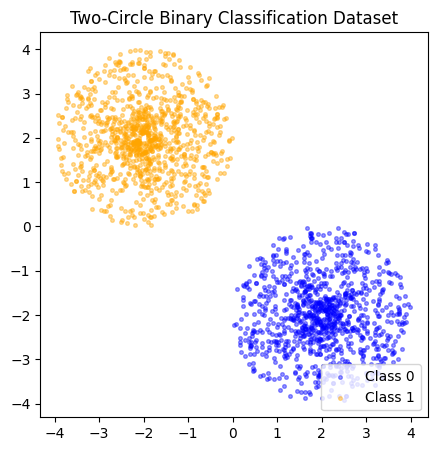

In [ ]:
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(5,5),sharey=True,sharex=True)

ax1.scatter(label0_data[:,0],label0_data[:,1],c='blue',alpha=0.4,s=7,label='Class 0')
ax1.scatter(label1_data[:,0],label1_data[:,1],c='orange',alpha=0.4,s=7, label='Class 1')
ax1.set_title('Two-Circle Binary Classification Dataset')
ax1.legend(loc='lower right')
ax1.plot()

### <font color=#41A317> 3.1.1 Fixed step  </font>

In [ ]:
# Convert the function into a string of text
f = 'fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 100.0
Loglikelihood : nan
Iterations : 2
Execution time:  1.48


Execution time:  256.4


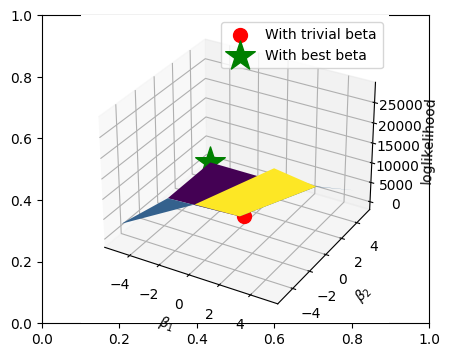

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 100.0
Loglikelihood : 0.02
Iterations : 150
Execution time:  53.91


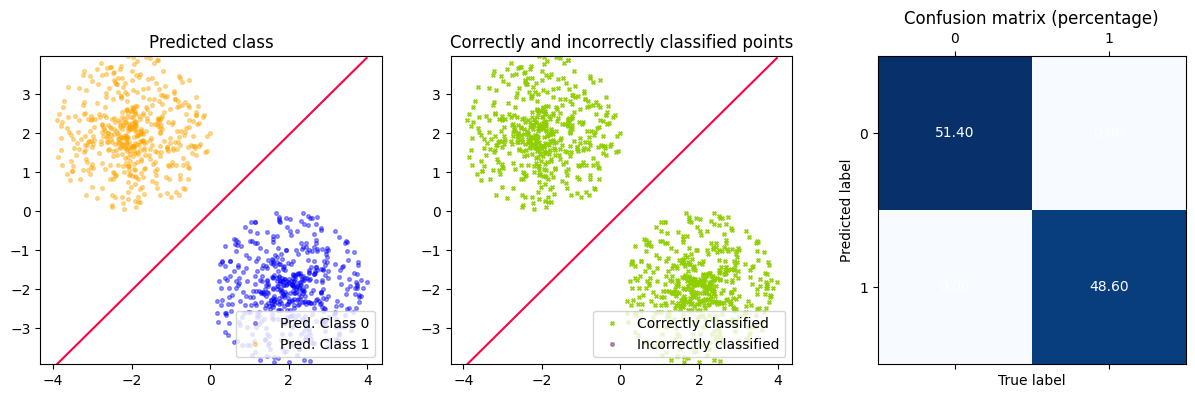

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.2 Newton Raphson </font>

In [ ]:
# Convert the function into a string of text
f = 'newton_method'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 100.0
Loglikelihood : nan
Iterations : 12
Execution time:  4.46


Execution time:  7.78


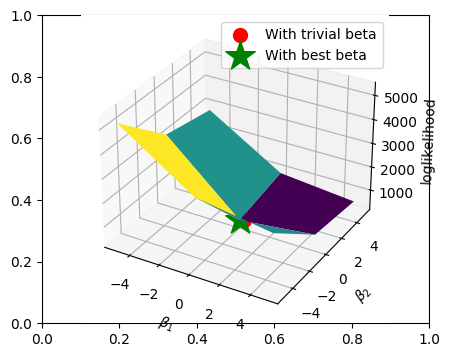

In [ ]:
# Finding the best beta

B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 100.0
Loglikelihood : nan
Iterations : 1
Execution time:  0.47


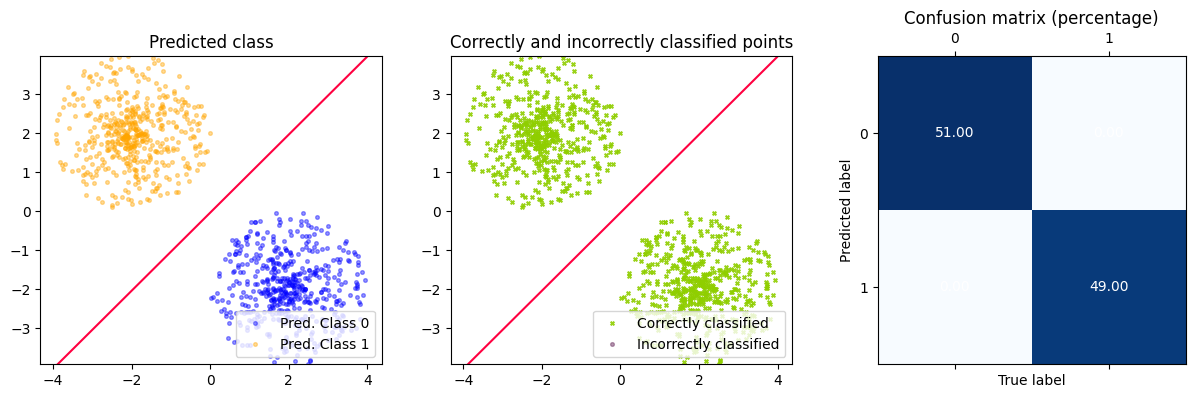

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.3 Barzilai and Borwein </font>

In [ ]:
# Convert the function into a string of text
f = 'BB_fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 100.0
Loglikelihood : nan
Iterations : 1
Execution time:  0.37


Execution time:  8.86


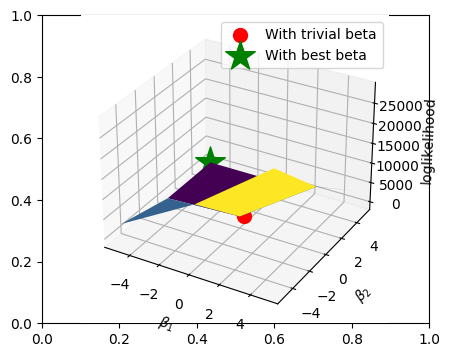

In [ ]:
# Finding the best beta

B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 100.0
Loglikelihood : nan
Iterations : 16
Execution time:  6.32


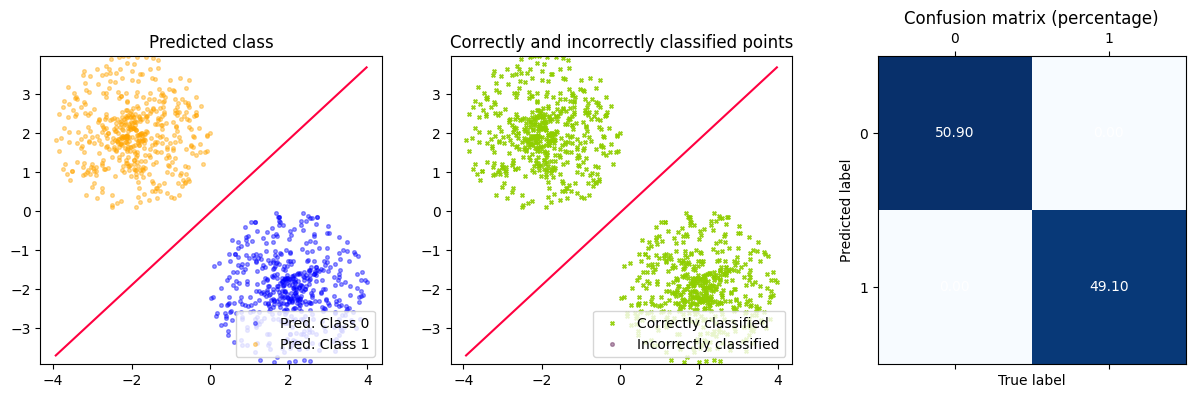

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

## <font color=#41A317> 3.2. Rejection Sampling with Uniform target distribution  </font>

In [ ]:
dataset= "Rejection Sampling with Uniform target distribution"

alpha, beta=1,1
c=1.7

B=stats.beta(a=alpha,b=beta)
U=stats.uniform()

y_k=U.rvs(size=n,random_state=rng)
sample_unif=U.rvs(size=n,random_state=rng)
f_y=B.pdf(y_k)
g_y= U.pdf(sample_unif)

#condicion rejet
condition=c*sample_unif*g_y<f_y

x_a = np.array([y_k[condition],c*sample_unif[condition]*g_y[condition]]).T
y_a = np.ones(len(x_a))

x_r = np.array([y_k[~condition],c*sample_unif[~condition]*g_y[~condition]]).T
y_r = np.zeros(len(x_r))

x = np.concatenate((x_a,x_r))
y = np.concatenate((y_a,y_r))

[]

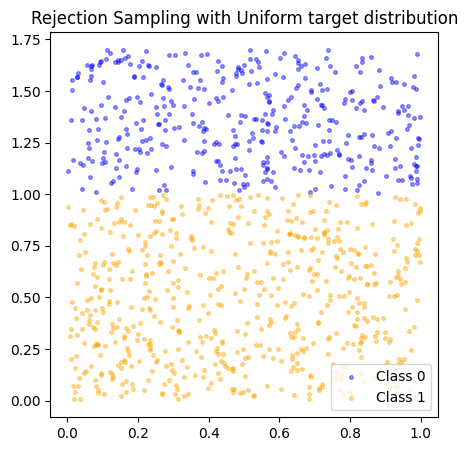

In [ ]:
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(5,5),sharey=True,sharex=True)

ax1.scatter(x_r[:,0],x_r[:,1],c='blue',alpha=0.4,s=7,label='Class 0')
ax1.scatter(x_a[:,0],x_a[:,1],c='orange',alpha=0.4,s=7, label='Class 1')
ax1.set_title('Rejection Sampling with Uniform target distribution')
ax1.legend(loc='lower right')
ax1.plot()

### <font color=#41A317> 3.1.1 Fixed step  </font>

In [ ]:
# Convert the function into a string of text
f = 'fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 99.80000000000001
Loglikelihood : 22.52
Iterations : 150
Execution time:  28.17


Execution time:  130.69


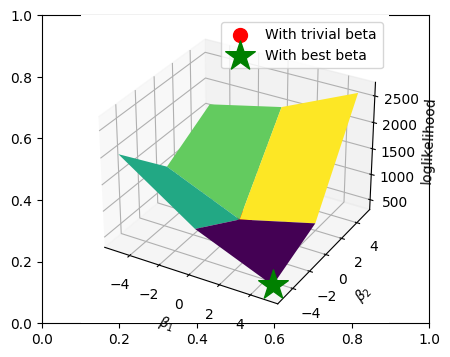

In [ ]:
# Finding the best beta

B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 99.4
Loglikelihood : 20.16
Iterations : 150
Execution time:  29.33


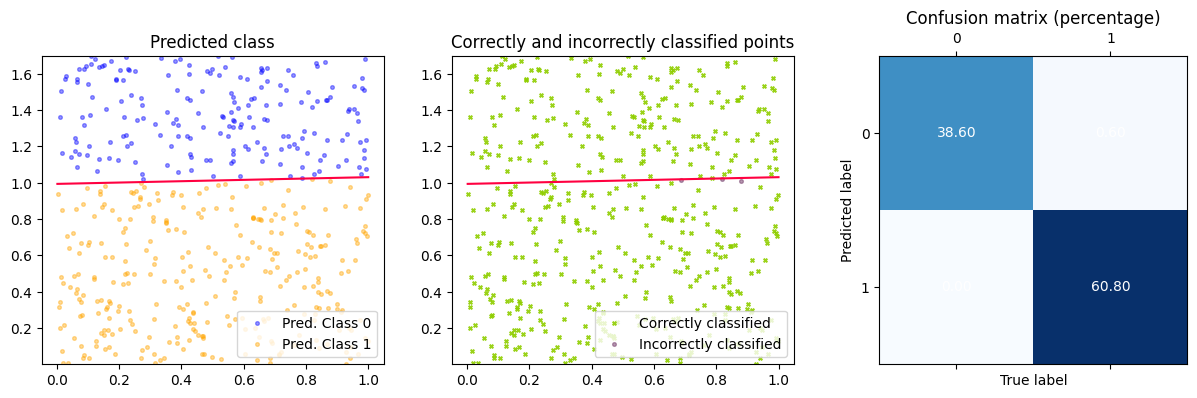

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.2 Newton Raphson </font>

In [ ]:
# Convert the function into a string of text
f = 'newton_method'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 99.4
Loglikelihood : nan
Iterations : 7
Execution time:  1.82


Execution time:  2.61


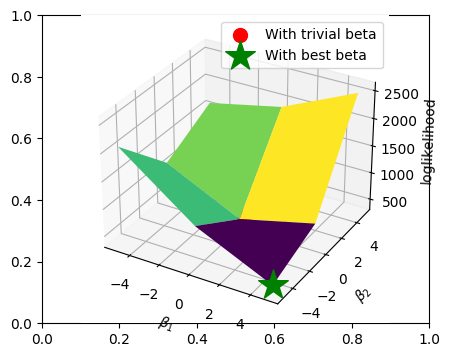

In [ ]:
# Finding the best beta

B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 99.8
Loglikelihood : nan
Iterations : 7
Execution time:  1.42


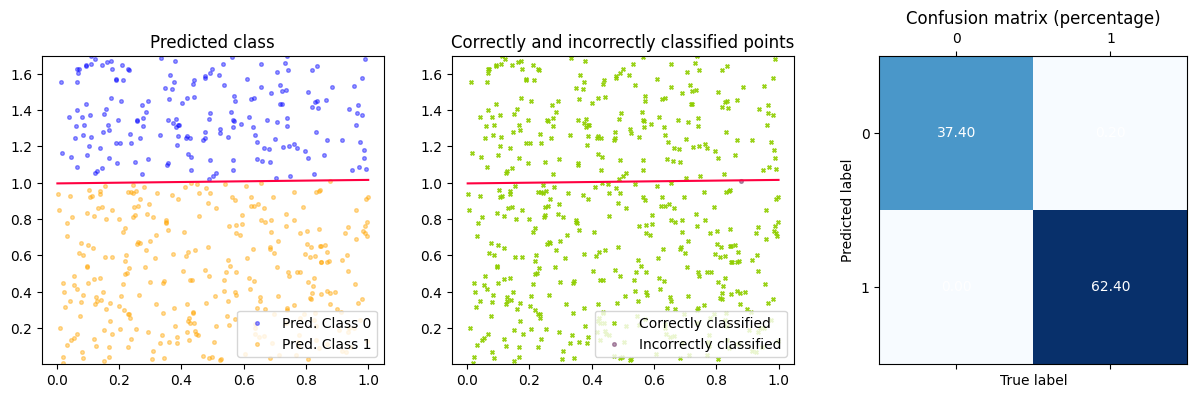

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.3 Barzilai and Borwein </font>

In [ ]:
# Convert the function into a string of text
f = 'BB_fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 91.79999999999998
Loglikelihood : nan
Iterations : 150
Execution time:  27.94


Execution time:  47.93


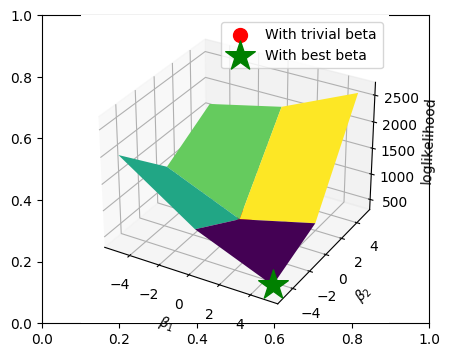

In [ ]:
# Finding the best beta

B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 99.8
Loglikelihood : nan
Iterations : 150
Execution time:  28.25


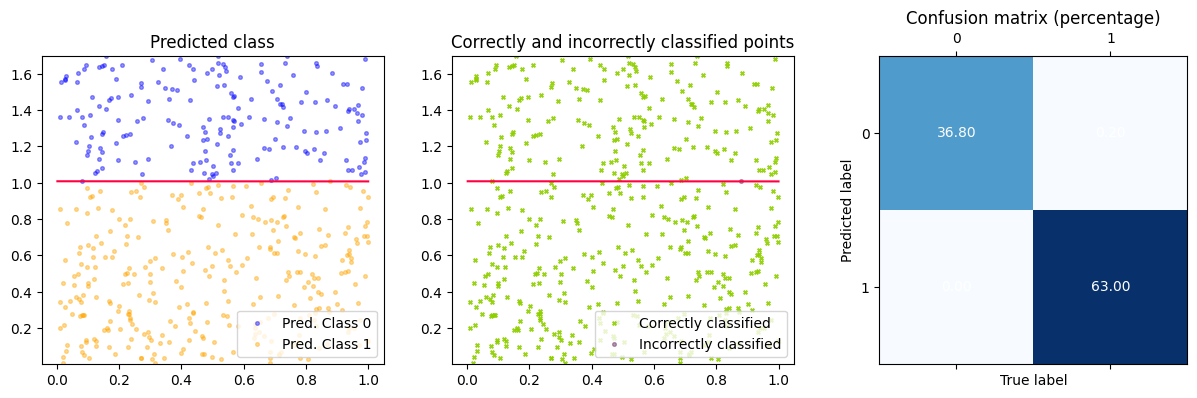

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

## <font color=#41A317> 3.3. Rejection Sampling with Beta target distribution  </font>

In [ ]:
dataset="Rejection Sampling with Beta target distribution"

alpha, beta=2,2
c=1.7

B=stats.beta(a=alpha,b=beta)
U=stats.uniform()

y_k=U.rvs(size=n,random_state=rng)
sample_unif=U.rvs(size=n,random_state=rng)
f_y=B.pdf(y_k)
g_y= U.pdf(sample_unif)

#condicion rejet
condition=c*sample_unif*g_y<f_y

x_a = np.array([y_k[condition],c*sample_unif[condition]*g_y[condition]]).T
y_a = np.ones(len(x_a))

x_r = np.array([y_k[~condition],c*sample_unif[~condition]*g_y[~condition]]).T
y_r = np.zeros(len(x_r))

x = np.concatenate((x_a,x_r))
y = np.concatenate((y_a,y_r))

[]

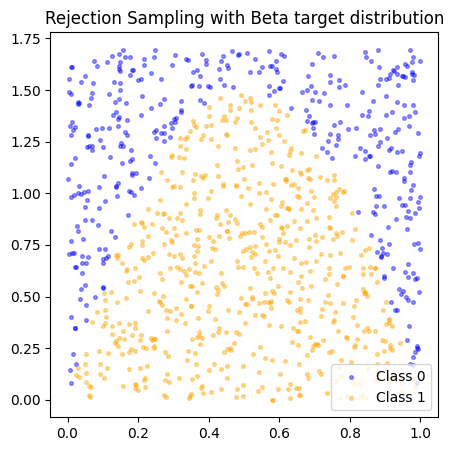

In [ ]:
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(5,5),sharey=True,sharex=True)

ax1.scatter(x_r[:,0],x_r[:,1],c='blue',alpha=0.4,s=7,label='Class 0')
ax1.scatter(x_a[:,0],x_a[:,1],c='orange',alpha=0.4,s=7, label='Class 1')
ax1.set_title('Rejection Sampling with Beta target distribution')
ax1.legend(loc='lower right')
ax1.plot()

### <font color=#41A317> 3.1.1 Fixed step  </font>

In [ ]:
# Convert the function into a string of text
f = 'fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 73.6
Loglikelihood : 801.96
Iterations : 150
Execution time:  28.84


Execution time:  126.4


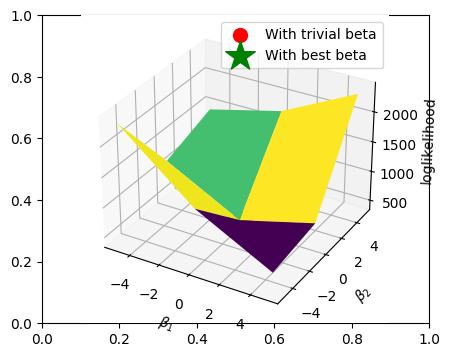

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 68.80000000000001
Loglikelihood : 1029.31
Iterations : 150
Execution time:  28.86


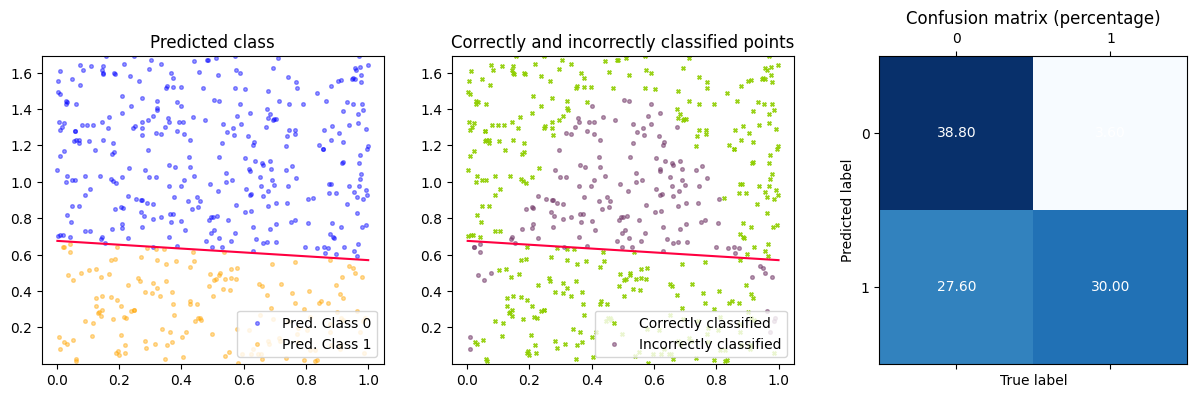

In [ ]:
# best beta
beta_0=B_beta


iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.2 Newton Raphson </font>

In [ ]:
# Convert the function into a string of text
f = 'newton_method'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 77.39999999999999
Loglikelihood : 239.83
Iterations : 5
Execution time:  0.97


Execution time:  1.69


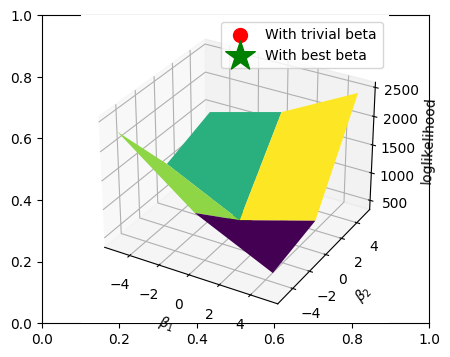

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 77.8
Loglikelihood : 231.24
Iterations : 5
Execution time:  1.04


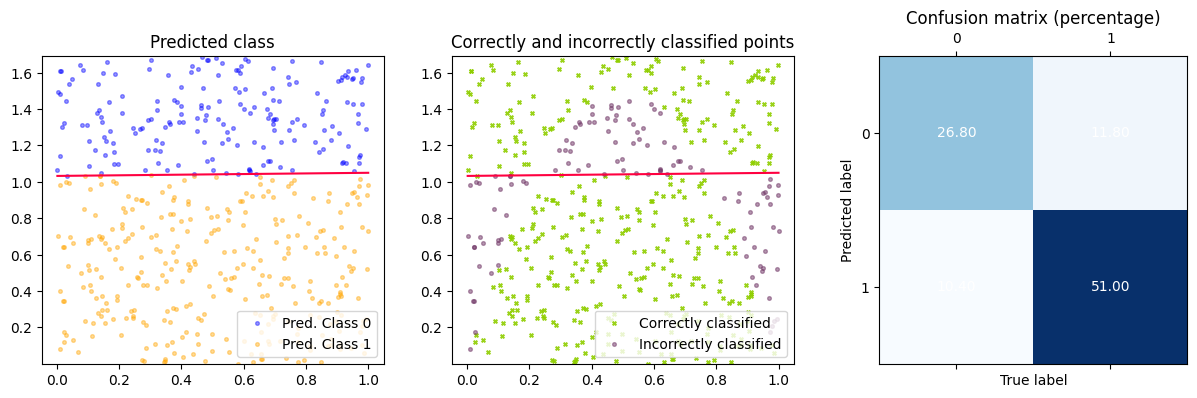

In [ ]:
# best beta
beta_0=B_beta


iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.3 Barzilai and Borwein </font>

In [ ]:
# Convert the function into a string of text
f = 'BB_fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 79.0
Loglikelihood : 231.69
Iterations : 30
Execution time:  5.77


Execution time:  7.23


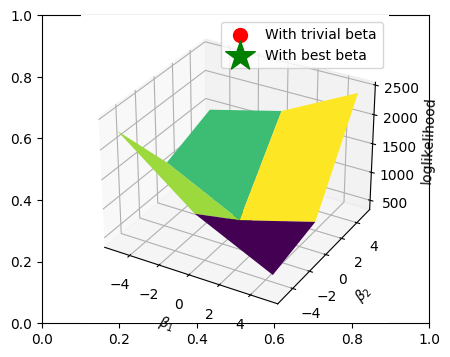

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 80.8
Loglikelihood : 220.79
Iterations : 30
Execution time:  6.03


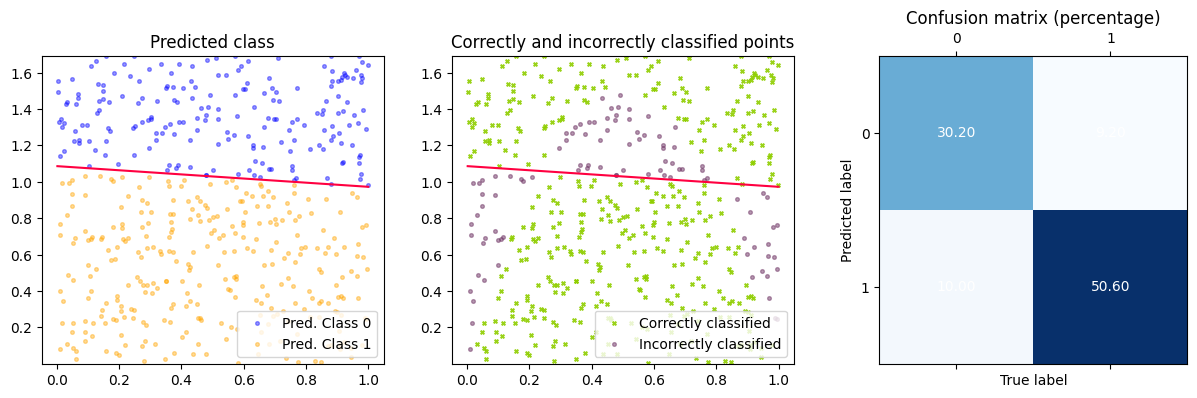

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

## <font color=#41A317> 3.4. Logistic Regression with Correlated Features </font>

In [ ]:
dataset="Logistic Regression with Correlated Features"

# Define number of samples
num_samples = n

# Define mean and variance of features
mean_X1 = 0

var_X1 =2
mean_X2 = 0
var_X2 = 2

# Define features
X1 = rng.normal(loc=mean_X1, scale=np.sqrt(var_X1), size=num_samples)
X2 = rng.normal(loc=mean_X2, scale=np.sqrt(var_X2), size=num_samples)

# Define coefficients
beta_0 = 0
beta_1 = 1
beta_2 = 1

# Calculate probability of class 1
logits = beta_0 + beta_1*X1 + beta_2*X2
probs = 1 / (1 + np.exp(-logits))

# Generate target variable
Y = rng.binomial(n=1, p=probs)

x = np.array([X1,X2]).T
y = Y

[]

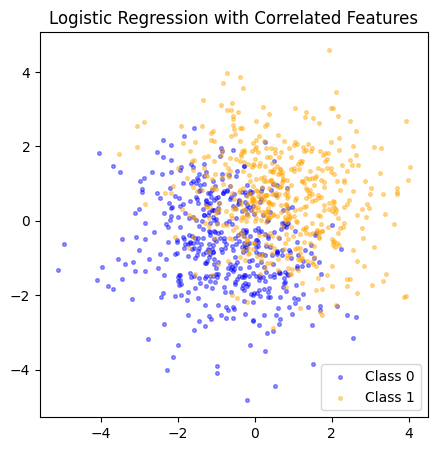

In [ ]:
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(5,5),sharey=True,sharex=True)

ax1.scatter(X1[Y==0], X2[Y==0],c='blue',alpha=0.4,s=7,label='Class 0')
ax1.scatter(X1[Y==1], X2[Y==1],c='orange',alpha=0.4,s=7, label='Class 1')
ax1.set_title('Logistic Regression with Correlated Features')
ax1.legend(loc='lower right')
ax1.plot()

### <font color=#41A317> 3.1.1 Fixed step  </font>

In [ ]:
# Convert the function into a string of text
f = 'fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 70.4
Loglikelihood : 1124.47
Iterations : 150
Execution time:  27.38


Execution time:  124.53


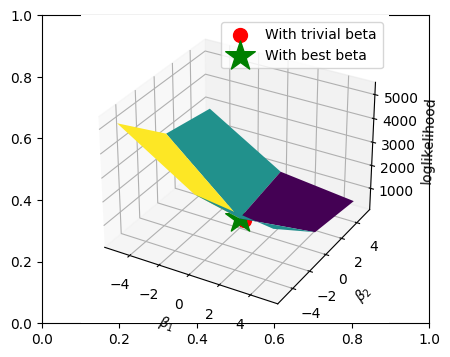

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 73.4
Loglikelihood : 703.67
Iterations : 150
Execution time:  28.03


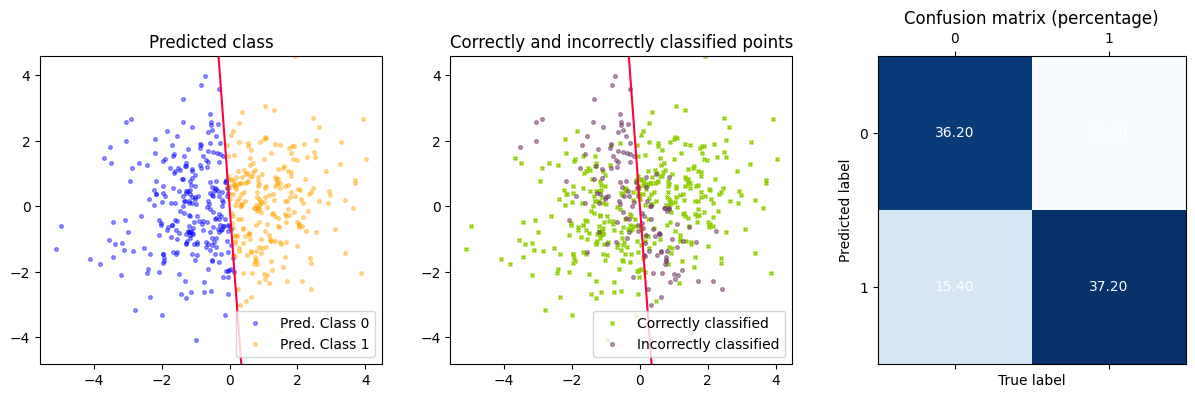

In [ ]:
# best beta
beta_0=B_beta


iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.2 Newton Raphson </font>

In [ ]:
# Convert the function into a string of text
f = 'newton_method'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 79.4
Loglikelihood : 205.36
Iterations : 6
Execution time:  1.11


Execution time:  1.89


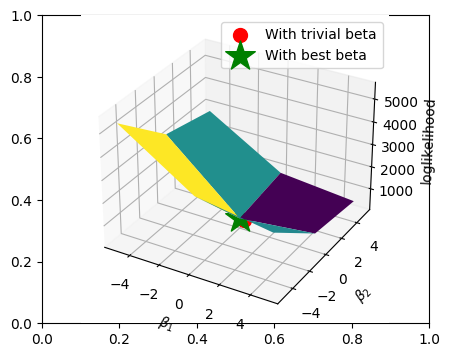

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 81.19999999999999
Loglikelihood : 195.11
Iterations : 6
Execution time:  1.59


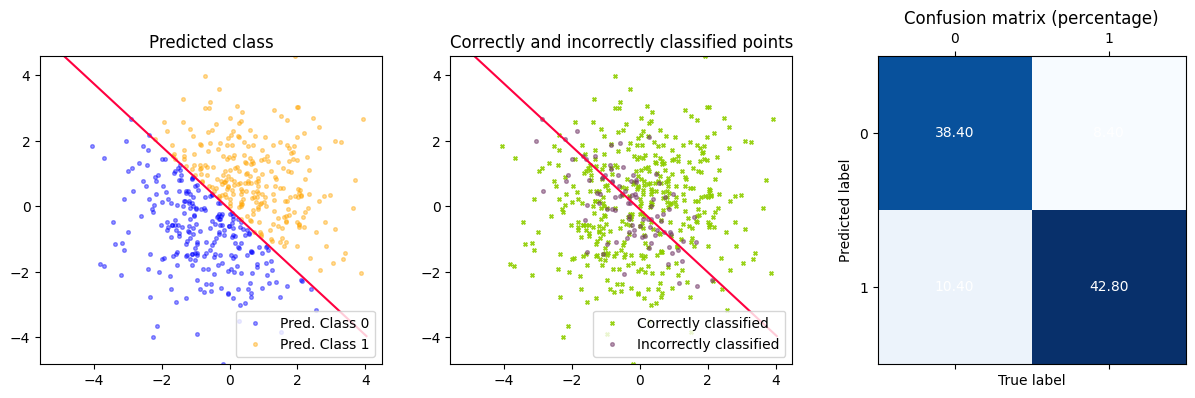

In [ ]:
# best beta
beta_0=B_beta


iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

### <font color=#41A317> 3.1.3 Barzilai and Borwein </font>

In [ ]:
# Convert the function into a string of text
f = 'BB_fixed_step'

In [ ]:
# Trivial beta
beta_0=np.ones(x.shape[1]+1)*0.2

# Applying the method to the dataset
iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=estimation_evaluation_method(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)

#Saving results to a dataframe
values=[dataset,f,iterations,duration,log_lik,accuracy]
T_results.loc[len(T_results)]=values

Accuracy : 78.6
Loglikelihood : 223.39
Iterations : 25
Execution time:  4.91


Execution time:  6.69


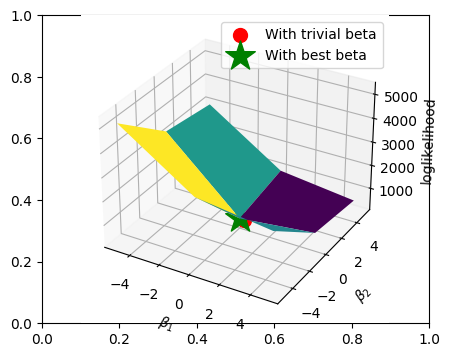

In [ ]:
# Finding the best beta
B_beta,duration_find_beta=best_beta(eval(f),x,y,beta_0,percentage=0.7)

Accuracy : 79.0
Loglikelihood : 205.5
Iterations : 24
Execution time:  4.47


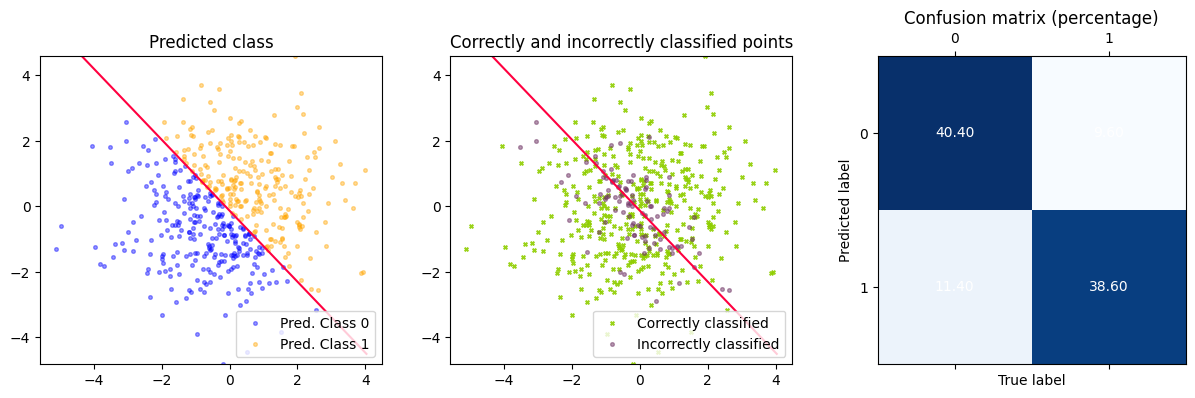

In [ ]:
# best beta
beta_0=B_beta

iterations,predictions,x_test,y_test,beta_apprx,accuracy, cm, log_lik,duration=summary(eval(f),x,y,beta_0,rho,percentage,threshold,max_iterations)
values=[dataset,f,duration_find_beta,beta_0,iterations,duration,log_lik,accuracy]
B_results.loc[len(B_results)]=values

## <font color=#41A317> 4. Analysis and Conclusions </font>

In [ ]:
# join results

results=pd.merge(T_results, B_results, on=['Dataset', 'Method'])

The columns that begin with "T" correspond to results using the *trivial beta*, while those that begin with "B" correspond to results using the *best beta*,
and Time_Find_B_Beta: Execution time to fin the best beta 

In [ ]:
results

,Dataset,Method,T_Iterations,T_Execution,T_Loglike,T_Accuracy,Time_Find_B_Beta,B_Beta,B_Iterations,B_Execution,B_Loglike,B_Accuracy
0,Two-Circle Binary Classification Dataset,fixed_step,2,1.48,NaN,100.0,256.40,"[0.2, -5.0, 5.0]",150,53.91,0.02,100.0
1,Two-Circle Binary Classification Dataset,newton_method,12,4.46,NaN,100.0,1.05,"[0.2, -5.0, 5.0]",1,0.47,NaN,100.0
2,Two-Circle Binary Classification Dataset,BB_fixed_step,1,0.37,NaN,100.0,8.86,"[0.2, -5.0, 5.0]",16,6.32,NaN,100.0
3,Rejection Sampling with Uniform target distrib...,fixed_step,150,28.17,22.52,99.8,130.69,"[0.2, 5.0, -5.0]",150,29.33,20.16,99.4
4,Rejection Sampling with Uniform target distrib...,newton_method,7,1.82,NaN,99.4,2.61,"[0.2, 5.0, -5.0]",7,1.42,NaN,99.8
5,Rejection Sampling with Uniform target distrib...,BB_fixed_step,150,27.94,NaN,91.8,47.93,"[0.2, 5.0, -5.0]",150,28.25,NaN,99.8
6,Rejection Sampling with Beta target distribution,fixed_step,150,28.84,801.96,73.6,126.40,"[0.2, 0.0, 0.0]",150,28.86,1029.31,68.8
7,Rejection Sampling with Beta target distribution,newton_method,5,0.97,239.83,77.4,1.69,"[0.2, 0.0, 0.0]",5,1.04,231.24,77.8
8,Rejection Sampling with Beta target distribution,BB_fixed_step,30,5.77,231.69,79.0,7.23,"[0.2, 0.0, 0.0]",30,6.03,220.79,80.8
9,Logistic Regression with Correlated Features,fixed_step,150,27.38,1124.47,70.4,124.53,"[0.2, 0.0, 0.0]",150,28.03,703.67,73.4


The methods perform very well on the first two datasets, achieving an accuracy close to 100% due to their linear separability, which means that a straight line can perfectly separate the two classes in the dataset. However, as the decision boundary becomes more complex, the accuracy decreases.

Therefore, the methods do not perform well on Rejection Sampling with Beta target distribution and Logistic Regression with Correlated Features as they are not linearly separable. Nonetheless, Newton and Barzilai Borwein methods achieve an accuracy of around 80% for these datasets, which is still reasonable. 

These methods outperform gradient descent with fixed steps in terms of accuracy and number of iterations, due to their use of second derivatives and adaptive step size, respectively. This enables them to take more direct steps towards the minimum of the objective function and adapt better to the complex nature of the decision boundary. 

In general, Newton method is the most advantegous in terms of convergence as it makes uses of the second order information, which can accelerate convergence by providing more information about the curvature of the loglikelihood function.

Regarding the sensitivity to the initial value of beta, the reported accuracies with the best beta are higher than the ones obtained with the trivial beta without increasing the number of iterations, especially in the non-linear separable datasets. This suggests that a preliminary calibration of the initial value of beta is worthwhile as the optimization problem becomes more complex.
